In [553]:
# External
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import importlib
import traceback

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [554]:
module_path = os.path.abspath(os.path.join('..'))
module_path, os.getcwd()

('/Users/nace/dev/esg-portfolio', '/Users/nace/dev/esg-portfolio/db')

In [555]:
from esgtools.utils import sql_manager

In [557]:
sql = sql_manager.ManagerSQL()

# Pre-processing

### Returns, prices, shares

In [1]:
crsp_prices = pd.read_csv("data/crsp_prices_sel.csv")

In [33]:
crsp_prices.shape

(101150729, 11)

In [34]:
crsp_prices.head()

,PERMNO,PrimaryExch,ShareClass,Ticker,DlyCalDt,DlyPrc,DlyRet,DlyVol,DlyBid,DlyAsk,ShrOut
0,10000,Q,A,OMFGA,19860107,2.5625,NaN,1000.0,2.375,2.75,3680.0
1,10000,Q,A,OMFGA,19860108,2.5,-0.02439,12800.0,2.375,2.625,3680.0
2,10000,Q,A,OMFGA,19860109,2.5,0.00000,1400.0,2.375,2.625,3680.0
3,10000,Q,A,OMFGA,19860110,2.5,0.00000,8500.0,2.375,2.625,3680.0
4,10000,Q,A,OMFGA,19860113,2.625,0.05000,5450.0,2.5,2.75,3680.0


In [35]:
crsp_prices.columns = [col.lower() for col in crsp_prices.columns]

In [36]:
crsp_prices['date'] = pd.to_datetime(crsp_prices.dlycaldt, format='%Y%m%d')

In [37]:
crsp_prices.head()

,permno,primaryexch,shareclass,ticker,dlycaldt,dlyprc,dlyret,dlyvol,dlybid,dlyask,shrout,date
0,10000,Q,A,OMFGA,19860107,2.5625,NaN,1000.0,2.375,2.75,3680.0,1986-01-07
1,10000,Q,A,OMFGA,19860108,2.5,-0.02439,12800.0,2.375,2.625,3680.0,1986-01-08
2,10000,Q,A,OMFGA,19860109,2.5,0.00000,1400.0,2.375,2.625,3680.0,1986-01-09
3,10000,Q,A,OMFGA,19860110,2.5,0.00000,8500.0,2.375,2.625,3680.0,1986-01-10
4,10000,Q,A,OMFGA,19860113,2.625,0.05000,5450.0,2.5,2.75,3680.0,1986-01-13


In [38]:
crsp_prices_month = crsp_prices.set_index('date').groupby('permno').resample('BM').last()

In [39]:
crsp_prices_month.shape

(4804064, 11)

In [40]:
crsp_prices_month.head()

permno primaryexch shareclass ticker  dlycaldt  dlyprc  \
permno date                                                                 
10000  1986-01-31   10000           Q          A  OMFGA  19860131   4.375   
       1986-02-28   10000           Q          A  OMFGA  19860228    3.25   
       1986-03-31   10000           Q          A  OMFGA  19860331  4.4375   
       1986-04-30   10000           Q          A  OMFGA  19860430     4.0   
       1986-05-30   10000           Q          A  OMFGA  19860530  3.1094   

                     dlyret  dlyvol  dlybid  dlyask  shrout  
permno date                                                  
10000  1986-01-31 -0.014085  4650.0    4.25     4.5  3680.0  
       1986-02-28  0.000000  2900.0   3.125   3.375  3680.0  
       1986-03-31  0.007092  2000.0   4.375     4.5  3680.0  
       1986-04-30 -0.015385  1070.0   3.875   4.125  3793.0  
       1986-05-30  0.015306  7000.0  3.0625  3.1563  3793.0

In [41]:
crsp_prices['dlycontret'] = np.log(1 + crsp_prices.dlyret.fillna(0))

In [42]:
crsp_prices_month_ret = crsp_prices.set_index('date').groupby('permno').resample('BM')['dlycontret'].sum()

In [43]:
crsp_prices_month_ret.shape

(4804064,)

In [49]:
crsp_prices_month_ret.head()

permno  date      
10000   1986-01-31    0.534923
        1986-02-28   -0.297250
        1986-03-31    0.311436
        1986-04-30   -0.103800
        1986-05-30   -0.251874
Name: dlycontret, dtype: float64

In [50]:
crsp_prices_month_std = crsp_prices.set_index('date').groupby('permno').resample('BM')['dlyret'].std()

In [51]:
crsp_prices_month_std.shape

(4804064,)

In [52]:
crsp_prices_month_std.head()

permno  date      
10000   1986-01-31    0.065278
        1986-02-28    0.031004
        1986-03-31    0.044548
        1986-04-30    0.011246
        1986-05-30    0.038862
Name: dlyret, dtype: float64

In [63]:
agg_map = {'dlyvol': np.sum, 'dlycontret': np.sum, 'dlyret': np.std, 'permno': len}
agg_rename = {'dlyvol': 'volume_month', 'dlycontret': 'cont_ret_month', 'dlyret': 'std_month', 'permno': 'day_count'}
crsp_prices_month_agg = (
    crsp_prices
        .set_index('date')
        .groupby('permno')
        .resample('BM')
        .agg(agg_map)
        .rename(columns=agg_rename)
)

In [ ]:
#cont_ret_month

In [64]:
crsp_prices_month_agg

volume_month  ret_month  std_month  day_count
permno date                                                     
10000  1986-01-31      177082.0   0.534923   0.065278         19
       1986-02-28       82800.0  -0.297250   0.031004         19
       1986-03-31      107801.0   0.311436   0.044548         20
       1986-04-30       95700.0  -0.103800   0.011246         22
       1986-05-30      107362.0  -0.251874   0.038862         21
...                         ...        ...        ...        ...
93436  2021-11-30   645719701.0   0.027238   0.044202         21
       2021-12-31   507511834.0  -0.079969   0.038034         22
       2022-01-31   636164125.0  -0.120596   0.057041         20
       2022-02-28   460954079.0  -0.073398   0.038754         19
       2022-03-31   574261429.0   0.213503   0.036698         23

[4804064 rows x 4 columns]

In [65]:
cols = [
    'permno',
    'primaryexch',
    'shareclass',
    'ticker',
    'dlycaldt',
    'dlyprc',
    'dlybid',
    'dlyask',
    'shrout'
]

In [66]:
crsp_month = (
    crsp_prices_month[cols]
        .join(crsp_prices_month_agg)
)

In [67]:
crsp_month.head()

permno primaryexch shareclass ticker  dlycaldt  dlyprc  \
permno date                                                                 
10000  1986-01-31   10000           Q          A  OMFGA  19860131   4.375   
       1986-02-28   10000           Q          A  OMFGA  19860228    3.25   
       1986-03-31   10000           Q          A  OMFGA  19860331  4.4375   
       1986-04-30   10000           Q          A  OMFGA  19860430     4.0   
       1986-05-30   10000           Q          A  OMFGA  19860530  3.1094   

                   dlybid  dlyask  shrout  volume_month  ret_month  std_month  \
permno date                                                                     
10000  1986-01-31    4.25     4.5  3680.0      177082.0   0.534923   0.065278   
       1986-02-28   3.125   3.375  3680.0       82800.0  -0.297250   0.031004   
       1986-03-31   4.375     4.5  3680.0      107801.0   0.311436   0.044548   
       1986-04-30   3.875   4.125  3793.0       95700.0  -0.103800   0.011246   
       1986-05-30  3.0625  3.1563  3793.0      107362.0  -0.251874   0.038862   

                   day_count  
permno date                   
10000  1986-01-31         19  
       1986-02-28         19  
       1986-03-31         20  
       1986-04-30         22  
       1986-05-30         21

In [68]:
crsp_month.shape

(4804064, 13)

In [69]:
crsp_month = crsp_month.drop(columns=['permno', 'dlycaldt']).reset_index()

In [70]:
crsp_month.head()

,permno,date,primaryexch,shareclass,ticker,dlyprc,dlybid,dlyask,shrout,volume_month,ret_month,std_month,day_count
0,10000,1986-01-31,Q,A,OMFGA,4.375,4.25,4.5,3680.0,177082.0,0.534923,0.065278,19
1,10000,1986-02-28,Q,A,OMFGA,3.25,3.125,3.375,3680.0,82800.0,-0.297250,0.031004,19
2,10000,1986-03-31,Q,A,OMFGA,4.4375,4.375,4.5,3680.0,107801.0,0.311436,0.044548,20
3,10000,1986-04-30,Q,A,OMFGA,4.0,3.875,4.125,3793.0,95700.0,-0.103800,0.011246,22
4,10000,1986-05-30,Q,A,OMFGA,3.1094,3.0625,3.1563,3793.0,107362.0,-0.251874,0.038862,21


In [92]:
crsp_month = crsp_month.sort_values(['permno', 'date'])

In [71]:
crsp_month['ret_month'] = np.exp(crsp_month['cont_ret_month']) - 1

In [73]:
crsp_month.head()

,permno,date,primaryexch,shareclass,ticker,dlyprc,dlybid,dlyask,shrout,volume_month,ret_month,std_month,day_count
0,10000,1986-01-31,Q,A,OMFGA,4.375,4.25,4.5,3680.0,177082.0,0.707317,0.065278,19
1,10000,1986-02-28,Q,A,OMFGA,3.25,3.125,3.375,3680.0,82800.0,-0.257142,0.031004,19
2,10000,1986-03-31,Q,A,OMFGA,4.4375,4.375,4.5,3680.0,107801.0,0.365385,0.044548,20
3,10000,1986-04-30,Q,A,OMFGA,4.0,3.875,4.125,3793.0,95700.0,-0.098594,0.011246,22
4,10000,1986-05-30,Q,A,OMFGA,3.1094,3.0625,3.1563,3793.0,107362.0,-0.222657,0.038862,21


In [74]:
crsp_month.shape

(4804064, 13)

In [79]:
cols = [
    'permno',
    'date',
    'primaryexch',
    'shareclass',
    'ticker',
    'dlyprc',
    'dlybid',
    'dlyask',
    'shrout',
    'std_month',
    'volume_month', 
    'ret_month'
]

In [80]:
wrds_returns = crsp_month[cols].rename(columns=
    {
        'primaryexch': 'primary_exch',
        'shareclass': 'share_class',
        'dlyprc': 'price', 
        'dlybid': 'bid', 
        'dlyask': 'ask',
    })

In [81]:
wrds_returns

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month
0,10000,1986-01-31,Q,A,OMFGA,4.375,4.25,4.5,3680.0,0.065278,177082.0,0.707317
1,10000,1986-02-28,Q,A,OMFGA,3.25,3.125,3.375,3680.0,0.031004,82800.0,-0.257142
2,10000,1986-03-31,Q,A,OMFGA,4.4375,4.375,4.5,3680.0,0.044548,107801.0,0.365385
3,10000,1986-04-30,Q,A,OMFGA,4.0,3.875,4.125,3793.0,0.011246,95700.0,-0.098594
4,10000,1986-05-30,Q,A,OMFGA,3.1094,3.0625,3.1563,3793.0,0.038862,107362.0,-0.222657
...,...,...,...,...,...,...,...,...,...,...,...,...
4804059,93436,2021-11-30,Q,None,TSLA,"1,144.7600","1,144.5600","1,144.9900",1004265.0,0.044202,645719701.0,0.027612
4804060,93436,2021-12-31,Q,None,TSLA,"1,056.7800","1,056.8900","1,057.2400",1033508.0,0.038034,507511834.0,-0.076855
4804061,93436,2022-01-31,Q,None,TSLA,936.7200,936.0000,936.8300,1033508.0,0.057041,636164125.0,-0.113608
4804062,93436,2022-02-28,Q,None,TSLA,870.4300,870.7800,871.1400,1033508.0,0.038754,460954079.0,-0.070769


In [82]:
wrds_returns.shape

(4804064, 12)

In [84]:
not_missing_cond = \
    ~wrds_returns.price.isnull() \
    & ~wrds_returns.shrout.isnull()
wrds_returns = wrds_returns.loc[not_missing_cond].reset_index(drop=True)

In [85]:
wrds_returns.iloc[148650:]

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month
148650,10933,2021-04-30,N,None,MKL,"1,176.4200","1,173.4300","1,175.8600",13758.0,0.009495,889523.0,0.032290
148651,10933,2021-05-31,N,None,MKL,"1,225.4900","1,225.4900","1,227.7900",13758.0,0.015429,1311026.0,0.041713
148652,10933,2021-06-30,N,None,MKL,"1,186.7100","1,186.7200","1,189.6300",13758.0,0.011551,1040531.0,-0.031643
148653,10933,2021-07-30,N,None,MKL,"1,206.1700","1,206.3700","1,207.5000",13758.0,0.016868,1036376.0,0.016395
148654,10933,2021-08-31,N,None,MKL,"1,270.2500","1,268.0000","1,268.0100",13725.0,0.008848,651795.0,0.053126
...,...,...,...,...,...,...,...,...,...,...,...,...
4718081,93436,2021-11-30,Q,None,TSLA,"1,144.7600","1,144.5600","1,144.9900",1004265.0,0.044202,645719701.0,0.027612
4718082,93436,2021-12-31,Q,None,TSLA,"1,056.7800","1,056.8900","1,057.2400",1033508.0,0.038034,507511834.0,-0.076855
4718083,93436,2022-01-31,Q,None,TSLA,936.7200,936.0000,936.8300,1033508.0,0.057041,636164125.0,-0.113608
4718084,93436,2022-02-28,Q,None,TSLA,870.4300,870.7800,871.1400,1033508.0,0.038754,460954079.0,-0.070769


In [87]:
wrds_returns['shrout'] = wrds_returns.shrout.astype(int)

In [88]:
format_nbr = lambda x: x.replace(',', '') if isinstance(x, str) else x
wrds_returns['price'] = pd.to_numeric(wrds_returns.price.map(format_nbr))
wrds_returns['bid'] = pd.to_numeric(wrds_returns.bid.map(format_nbr))
wrds_returns['ask'] = pd.to_numeric(wrds_returns.ask.map(format_nbr))

In [89]:
wrds_returns.head()

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month
0,10000,1986-01-31,Q,A,OMFGA,4.3750,4.2500,4.5000,3680,0.065278,177082.0,0.707317
1,10000,1986-02-28,Q,A,OMFGA,3.2500,3.1250,3.3750,3680,0.031004,82800.0,-0.257142
2,10000,1986-03-31,Q,A,OMFGA,4.4375,4.3750,4.5000,3680,0.044548,107801.0,0.365385
3,10000,1986-04-30,Q,A,OMFGA,4.0000,3.8750,4.1250,3793,0.011246,95700.0,-0.098594
4,10000,1986-05-30,Q,A,OMFGA,3.1094,3.0625,3.1563,3793,0.038862,107362.0,-0.222657


In [90]:
wrds_returns.iloc[148650:]

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month
148650,10933,2021-04-30,N,None,MKL,1176.42,1173.43,1175.86,13758,0.009495,889523.0,0.032290
148651,10933,2021-05-31,N,None,MKL,1225.49,1225.49,1227.79,13758,0.015429,1311026.0,0.041713
148652,10933,2021-06-30,N,None,MKL,1186.71,1186.72,1189.63,13758,0.011551,1040531.0,-0.031643
148653,10933,2021-07-30,N,None,MKL,1206.17,1206.37,1207.50,13758,0.016868,1036376.0,0.016395
148654,10933,2021-08-31,N,None,MKL,1270.25,1268.00,1268.01,13725,0.008848,651795.0,0.053126
...,...,...,...,...,...,...,...,...,...,...,...,...
4718081,93436,2021-11-30,Q,None,TSLA,1144.76,1144.56,1144.99,1004265,0.044202,645719701.0,0.027612
4718082,93436,2021-12-31,Q,None,TSLA,1056.78,1056.89,1057.24,1033508,0.038034,507511834.0,-0.076855
4718083,93436,2022-01-31,Q,None,TSLA,936.72,936.00,936.83,1033508,0.057041,636164125.0,-0.113608
4718084,93436,2022-02-28,Q,None,TSLA,870.43,870.78,871.14,1033508,0.038754,460954079.0,-0.070769


In [91]:
wrds_returns.loc[wrds_returns.price.isnull()]

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month


In [93]:
wrds_returns.loc[wrds_returns.shrout.isnull()]

,permno,date,primary_exch,share_class,ticker,price,bid,ask,shrout,std_month,volume_month,ret_month


In [94]:
wrds_returns.shape

(4718086, 12)

In [95]:
wrds_returns.to_csv('data/wrds_returns.csv', index=False)

### Financial ratios

In [ ]:
wrds_ratios = pd.read_csv("data/fin_ratios.csv")

In [152]:
wrds_ratios.shape

(2873221, 76)

In [153]:
wrds_ratios.head()

,gvkey,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,cusip
0,1000,25881,19691231.0,19700930.0,19710131,10.950,0.427,1.761,NaN,NaN,...,11.215,0.0,0.0,0.0,0.530,2.340,NaN,NaN,NaN,NaN
1,1000,25881,19701231.0,19701231.0,19710228,35.407,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,0.021,2.801,NaN,NaN,AE,00003210
2,1000,25881,19701231.0,19701231.0,19710331,31.031,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,0.021,2.455,NaN,NaN,AE,00003210
3,1000,25881,19701231.0,19701231.0,19710430,34.214,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,0.021,2.707,NaN,NaN,AE,00003210
4,1000,25881,19701231.0,19710331.0,19710531,11.307,0.431,7.010,NaN,NaN,...,25.817,0.0,0.0,0.0,0.021,2.172,NaN,NaN,AE,00003210


In [155]:
cols = ['permno', 'adate', 'qdate', 'public_date', 'bm', 'divyield', 'pcf', 'roa', 'roe']
wrds_ratios = wrds_ratios[cols]

In [157]:
wrds_ratios['adate'] = pd.to_datetime(wrds_ratios.adate.map(lambda x: str(x)[:8]), format="%Y%m%d")
wrds_ratios['qdate'] = pd.to_datetime(wrds_ratios.qdate, format="%Y%m%d")
wrds_ratios['public_date'] = pd.to_datetime(wrds_ratios.public_date, format="%Y%m%d")

In [158]:
wrds_ratios['divyield'] = pd.to_numeric(wrds_ratios.divyield, errors='coerce')

In [159]:
wrds_ratios['rnk'] = wrds_ratios.groupby(['permno', 'qdate'])['public_date'].rank(method='first')

In [160]:
wrds_ratios = wrds_ratios.sort_values(['permno', 'qdate', 'public_date'])

In [161]:
wrds_ratios.head()

,permno,adate,qdate,public_date,bm,divyield,pcf,roa,roe,rnk
1593305,10000,1985-10-31,1986-01-31,1986-03-31,0.044,NaN,-31.464,-0.599,NaN,1.0
1593306,10000,1985-10-31,1986-01-31,1986-04-30,0.044,NaN,-29.233,-0.599,NaN,2.0
1593307,10000,1985-10-31,1986-01-31,1986-05-31,0.044,NaN,-22.724,-0.599,NaN,3.0
1593308,10000,1985-10-31,1986-04-30,1986-06-30,0.039,NaN,-13.320,-0.826,-0.209,1.0
1593309,10000,1985-10-31,1986-04-30,1986-07-31,0.039,NaN,-12.243,-0.826,-0.209,2.0


In [162]:
wrds_ratios = wrds_ratios.loc[wrds_ratios.rnk == 1]

In [163]:
wrds_ratios = wrds_ratios.dropna(subset=['permno', 'qdate', 'public_date', 'bm'])

In [164]:
wrds_ratios.shape

(877143, 10)

In [167]:
wrds_ratios = wrds_ratios.drop(columns=['rnk'])

In [168]:
wrds_ratios.to_csv('data/wrds_ratios.csv', index=False)

# Factor Processing

In [331]:
query = f"select distinct date from returns_wrds"
bdates = sql.select_query(query)
bdates = bdates.date.sort_values()
eom_dates = bdates.groupby([bdates.dt.year, bdates.dt.month]).max().reset_index(drop=True)
eom_dates.head()

0   1925-12-31
1   1926-01-29
2   1926-02-26
3   1926-03-31
4   1926-04-30
Name: date, dtype: datetime64[ns]

In [332]:
query = """
select permno, qdate, public_date, bm
from (
    select permno, qdate, public_date, bm, dense_rank() over (partition by qdate order by public_date) rnk
    from ratios_wrds
    where bm is not NULL
) a
where rnk = 1
"""
ratios = sql.select_query(query)
ratios.head()

,permno,qdate,public_date,bm
0,27457,1969-07-31,1970-01-31,0.836
1,30509,1969-09-30,1970-01-31,0.389
2,28564,1969-09-30,1970-01-31,0.397
3,29663,1969-09-30,1970-01-31,0.229
4,27203,1969-09-30,1970-01-31,0.371


In [505]:
query = """
select min(public_date) min_date
from ratios_wrds
where bm is not NULL
"""
bm_min_date = sql.select_query(query).iloc[0, 0]

In [506]:
bm_min_date

Timestamp('1970-01-31 00:00:00')

In [333]:
eom_dates = eom_dates.loc[eom_dates >= ratios.public_date.min()]
eom_dates.head()

530   1970-02-27
531   1970-03-31
532   1970-04-30
533   1970-05-29
534   1970-06-30
Name: date, dtype: datetime64[ns]

In [334]:
eom_dates.tail()

1151   2021-11-30
1152   2021-12-31
1153   2022-01-31
1154   2022-02-28
1155   2022-03-31
Name: date, dtype: datetime64[ns]

### Size

In [105]:
df_size = pd.DataFrame()
for date in eom_dates:
    print(date, end="\r")
    df_size = df_size.append(process_size(date))

In [336]:
df_size.shape

(1247905, 11)

In [337]:
df_size.head()

,permno,date,share_class,ticker,price,shrout,size,bm,std_month,volume_month,ret_month
0,12490,1970-02-27,None,IBM,340.250,113718,38692550,0.130,0.012034,615100.0,0.018510
1,10401,1970-02-27,None,T,51.250,549264,28149780,0.797,0.010225,1572600.0,0.087080
2,12079,1970-02-27,None,GM,69.375,285763,19824808,0.424,0.013045,885400.0,0.097867
3,11754,1970-02-27,None,EK,79.875,161545,12903407,0.158,0.016363,837100.0,0.028981
4,11850,1970-02-27,None,XOM,54.000,223663,12077802,0.608,0.021947,1792600.0,-0.022956


## Momentum

In [338]:
ff.tail()

,date,rm-rf,smb,hml,rf,rm,cont_rm,cont_rf
25373,2022-11-23,0.0063,0.02,-0.94,0.00014,0.00644,0.006419,0.00014
25374,2022-11-25,-0.0002,0.22,0.44,0.00014,-0.00006,-0.000060,0.00014
25375,2022-11-28,-0.0155,-0.40,-0.20,0.00014,-0.01536,-0.015479,0.00014
25376,2022-11-29,-0.0018,0.10,1.03,0.00014,-0.00166,-0.001661,0.00014
25377,2022-11-30,0.0312,0.36,-2.07,0.00014,0.03134,0.030859,0.00014


In [127]:
ff['rf'] = ff['rf']/100
ff['rm-rf'] = ff['rm-rf']/100
ff['rm'] = ff['rm-rf']+ff['rf']
ff['cont_rm'] = np.log(1 + ff['rm'])
ff['cont_rf'] = np.log(1 + ff['rf'])

ff_month = ff.set_index('date').resample('BM')[['cont_rm', 'cont_rf']].sum()
ff_month['rm'] = np.exp(ff_month['cont_rm']) - 1
ff_month['rf'] = np.exp(ff_month['cont_rf']) - 1

In [365]:
date = eom_dates.iloc[-1]
#date = pd.Timestamp('2020-01-31 00:00:00')
date

Timestamp('2022-03-31 00:00:00')

In [ ]:
df = df_size.copy()
df = df.sort_values(['permno', 'date'])

In [367]:
# Get data for the date
#date_str = date.strftime('%Y-%m-%d')
#query = f"select * from returns_wrds where date = '{date_str}'"
#ret_date = sql.select_query(query)
ret_date = df.loc[df.date == date]
ret_date['cont_ret_month'] = np.log(1 + ret_date.ret_month)

# Relevant past dates
date_5y = date - relativedelta(years=5, days=-3)
date_12m = date - relativedelta(months=12, days=-3)
date_1m = date - relativedelta(months=1, days=-3)
date_str = date.strftime('%Y-%m-%d')
date_5y_str = date_5y.strftime('%Y-%m-%d')

date, date_5y, date_12m, date_1m

(Timestamp('2022-03-31 00:00:00'),
 Timestamp('2017-04-03 00:00:00'),
 Timestamp('2021-04-03 00:00:00'),
 Timestamp('2022-03-03 00:00:00'))

In [368]:
# Past data of relevant permnos
query = rf"""
select * from returns_wrds 
where date between '{date_5y_str}' and '{date_str}'
        and permno in ({','.join([str(permno) for permno in ret_date.permno])})
"""
ret_past = sql.select_query(query)
ret_past.loc[ret_past.ret_month == 0, 'ret_month'] = np.nan
ret_past['cont_ret_month'] = np.log(1 + ret_past.ret_month)
ret_past['var_month'] = ret_past['std_month']**2

In [369]:
ret_past.loc[ret_past.ret_month == 0, 'ret_month'] = np.nan

In [370]:
ret_past['cont_ret_month'] = np.log(1 + ret_past.ret_month)
ret_past['var_month'] = ret_past['std_month']**2

In [372]:
# 'mom', 'logret', date_12m, date_1m, sum, 5
name = 'mom'
target_col = 'cont_ret_month'
date_start = date_12m
date_end = date_1m
operation = sum
tolerance_months = 0

In [373]:
# 'vol', 'logret', date_5y, date, np.std, 10
name = 'std'
target_col = 'var_month'
date_start = date_5y
date_end = date
operation = lambda x: np.sqrt(np.mean(x)*12)
tolerance_months = 1

In [374]:
factor_past = (ret_past
                .loc[ret_past.date.between(date_start, date_end)]
                .groupby('permno').agg({target_col: [operation, len]})
                )
factor = factor_past.loc[factor_past.iloc[:, 1] >= factor_past.iloc[:, 1].max() - tolerance_months]
factor = pd.DataFrame(factor.iloc[:, 0].values, index=factor.index, columns=[name]).reset_index()

In [375]:
factor_past

var_month    
       <lambda_0> len
permno               
10026    0.068593  60
10032    0.073867  60
10104    0.061853  60
10107    0.062489  60
10138    0.066548  60
...           ...  ..
93369    0.103958  60
93374    0.066917  60
93423    0.114756  60
93429    0.061369  60
93436    0.135088  60

[2000 rows x 2 columns]

In [376]:
factor_past.iloc[:, 1].max()

60

In [377]:
factor

,permno,std
0,10026,0.068593
1,10032,0.073867
2,10104,0.061853
3,10107,0.062489
4,10138,0.066548
...,...,...
1570,93369,0.103958
1571,93374,0.066917
1572,93423,0.114756
1573,93429,0.061369


In [391]:
ret_beta['size'] = ret_beta['price']*ret_beta['shrout']
ret_beta = ret_beta.merge(ret_beta.groupby(['date'])[['size']].sum().rename(columns={'size': 'size_total'}), left_on='date', right_index=True)
ret_beta['weight'] = ret_beta['size']/ret_beta['size_total']
ret_beta['ret_month_weight'] = ret_beta['ret_month']*ret_beta['weight']

<AxesSubplot:xlabel='date'>

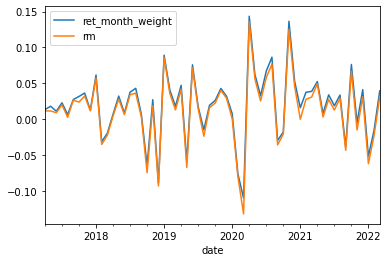

In [395]:
ret_beta.groupby(['date'])[['ret_month_weight', 'rm']].agg({'ret_month_weight': sum, 'rm': np.mean}).plot()

In [408]:
permnos = ret_date.permno.unique()
ret_beta = (ret_past \
                .loc[ret_past.date <= date_end]
                .merge(ff_month[['date', 'rm', 'rf']], how='inner', left_on='date', right_on='date')
            )
ret_beta['excess_asset'] = ret_beta['ret_month'] - ret_beta['rf']
ret_beta['excess_market'] = ret_beta['rm'] - ret_beta['rf']
months = ret_beta.groupby('permno')['date'].count().max()
beta = pd.DataFrame(index=ret_date.permno, columns=['beta']).reset_index()
for permno in permnos:
    beta_df = ret_beta.loc[ret_beta.permno == permno, ['excess_market', 'excess_asset']].dropna()
    beta_df = beta_df.loc[beta_df.excess_asset.abs() < 1]
    beta_df['log_excess_market'] = np.log(1 + beta_df['excess_market'])
    beta_df['log_excess_asset'] = np.log(1 + beta_df['excess_asset'])
    if (beta_df.shape[0] >= months - tolerance_months) and (beta_df.shape[0] > 0):
        x = beta_df[['excess_market']]
        y = beta_df['excess_asset']
        reg = LinearRegression(fit_intercept=False).fit(x, y)
        beta.loc[beta.permno == permno, 'beta'] = reg.coef_[0]

Text(0, 0.5, 'count')

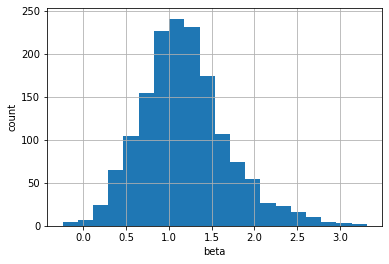

In [418]:
beta.beta.hist(bins=20)
plt.xlabel('beta')
plt.ylabel('count')

In [542]:
def process_size(date, n_companies=2000):
    """
        - Include Book to Market factor
        - Compute Size factor
        - Filter the largest 500 companies
        - Upload to database
    """
    
    # crsp_returns for the date
    date_str = date.strftime('%Y-%m-%d')
    query = f"select * from returns_wrds where date = '{date_str}'"
    ret_date = sql.select_query(query)

    # wrds_ratios for the date
    ratios_date = ratios.loc[ratios.public_date <= date]
    ratios_date = ratios_date.loc[ratios_date.groupby('permno')['public_date'].idxmax()]

    # Combine information
    df = ret_date.merge(ratios_date[['permno', 'bm']], how='inner', left_on='permno', right_on='permno')
    df['size'] = np.absolute(df['price'].multiply(df['shrout'])/1000).round(1)

    # Filter largest 500 companies
    df = df.sort_values('size', ascending=False).reset_index(drop=True).iloc[:n_companies]

    # Format
    cols = ['permno', 'date', 'share_class', 'ticker', 'price', 'shrout', 'size', 'bm', 'ret_month']
    df = df[cols]

    return df

In [543]:
def read_ff():

    # Read daily data
    ff = pd.read_csv("data/ff_daily.csv", skiprows=4).dropna()
    ff.columns = ['date', 'rm-rf', 'smb', 'hml', 'rf']
    ff['date'] = pd.to_datetime(ff.date)
    ff['rf'] = ff['rf']/100
    ff['rm-rf'] = ff['rm-rf']/100
    ff['rm'] = ff['rm-rf']+ff['rf']
    ff['cont_rm'] = np.log(1 + ff['rm'])
    ff['cont_rf'] = np.log(1 + ff['rf'])

    # Resample monthly
    ff_month = ff.set_index('date').resample('BM')[['cont_rm', 'cont_rf']].sum()
    ff_month['rm'] = np.exp(ff_month['cont_rm']) - 1
    ff_month['rf'] = np.exp(ff_month['cont_rf']) - 1
    ff_month = ff_month.drop(columns=['cont_rm', 'cont_rf'])

    return ff_month

In [565]:
def compute_factors(clean_table=True, date_start=None):
    
    # Clean table
    if clean_table:
        sql.clean_table('factor_exposures_wrds')
    
    # Dates
    query = f"select distinct date from returns_wrds order by date"
    dates = sql.select_query(query).date
    query = "select min(public_date) date from ratios_wrds where bm is not NULL"
    bm_min_date = sql.select_query(query).date.iloc[0]
    dates = dates.loc[dates >= bm_min_date]
    if date_start is not None:
        dates = dates.loc[dates >= date_start]
    print(dates)
    
    # Fama-French (for market returns and risk-free rate)
    ff = read_ff()
    
    # Compute factor for each date
    for date in dates:
        print(date.strftime('%Y-%m-%d'), end="\r")
        compute_factors_date(date, ff)

In [566]:
def compute_factors_date(date, ff, upload=True):
    
      # Dates
      date_str = date.strftime('%Y-%m-%d')
      date_5y = date - relativedelta(years=5, days=-3)
      date_12m = date - relativedelta(months=12, days=-3)
      date_1m = date - relativedelta(months=1, days=-3)
      date_f1m = date + relativedelta(months=1, days=5)
      date_str = date.strftime('%Y-%m-%d')
      date_5y_str = date_5y.strftime('%Y-%m-%d')
      date_f1m_str = date_f1m.strftime('%Y-%m-%d')

      # Size and value
      ret_date = process_size(date)
      ret_date = ret_date.merge(ff, left_on='date', right_index=True)

      # Past data of relevant permnos
      query = rf"""
      select * from returns_wrds 
      where date between '{date_5y_str}' and '{date_f1m_str}'
            and permno in ({','.join([str(permno) for permno in ret_date.permno])})
      """
      ret_past = sql.select_query(query)
      ret_past.loc[ret_past.ret_month == 0, 'ret_month'] = np.nan
      ret_past['cont_ret_month'] = np.log(1 + ret_past.ret_month)
      ret_past['var_month'] = ret_past['std_month']**2
      ret_past = ret_past.merge(ff, left_on='date', right_index=True)

      # Next month log return
      operation = lambda x: np.exp(np.sum(x)) - 1
      logret = compute_factor(ret_past, 'next_ret', 'cont_ret_month', date + relativedelta(days=1), date_f1m, operation, 0)
      ret_date = ret_date.merge(logret, how='left', left_on='permno', right_on='permno')

      # Beta
      beta = compute_beta(ret_date, ret_past, date)
      ret_date = ret_date.merge(beta, how='left', left_on='permno', right_on='permno')

      # Momentum
      mom = compute_factor(ret_past, 'mom', 'cont_ret_month', date_12m, date_1m, sum, 0)
      ret_date = ret_date.merge(mom, how='left', left_on='permno', right_on='permno')

      # Volatility
      operation = lambda x: np.sqrt(np.mean(x)*12)
      vol = compute_factor(ret_past, 'vol', 'var_month', date_5y, date, operation, 1)
      ret_date = ret_date.merge(vol, how='left', left_on='permno', right_on='permno')

      # Format
      cols = ['permno', 'date', 'share_class', 'ticker', 'beta', 
              'size', 'bm', 'mom', 'vol', 'rf', 'rm', 'ret_month', 'next_ret']
      ret_date = ret_date[cols]
      ret_date.rename(columns={'ret_month': 'ret'}, inplace=True)

      # Upload
      if upload:
            sql.upload_df_chunks('factor_exposures_wrds', ret_date, chunk_size=100)
      return ret_date



In [567]:
def compute_factor(ret_past, name, target_col, date_start, date_end, operation, tolerance_months):
    factor_past = (ret_past
                   .loc[ret_past.date.between(date_start, date_end)]
                   .groupby('permno').agg({target_col: [operation, len]})
                  )
    factor = factor_past.loc[factor_past.iloc[:, 1] >= factor_past.iloc[:, 1].max() - tolerance_months]
    factor = pd.DataFrame(factor.iloc[:, 0].values, index=factor.index, columns=[name]).reset_index()
    return factor

In [568]:
def compute_beta(ret_date, ret_past, date_end, tolerance_months=6):
    try:
        permnos = ret_date.permno.unique()
        ret_beta = ret_past.loc[ret_past.date <= date_end]
        ret_beta['excess_asset'] = ret_beta['ret_month'] - ret_beta['rf']
        ret_beta['excess_market'] = ret_beta['rm'] - ret_beta['rf']
        months = ret_beta.groupby('permno')['date'].count().max()
        beta = pd.DataFrame(index=ret_date.permno, columns=['beta']).reset_index()
        for permno in permnos:
            beta_df = ret_beta.loc[ret_beta.permno == permno, ['excess_market', 'excess_asset']].dropna()
            beta_df = beta_df.loc[beta_df.excess_asset.abs() < 1]
            beta_df['log_excess_market'] = np.log(1 + beta_df['excess_market'])
            beta_df['log_excess_asset'] = np.log(1 + beta_df['excess_asset'])
            if (beta_df.shape[0] >= months - tolerance_months) and (beta_df.shape[0] > 0):
                x = beta_df[['excess_market']]
                y = beta_df['excess_asset']
                reg = LinearRegression(fit_intercept=False).fit(x, y)
                beta.loc[beta.permno == permno, 'beta'] = reg.coef_[0]
        return beta
    except Exception as e:
        exc_type, exc_value, exc_tb = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_tb)        
        print("ff")
        print(ff.head())
        print("ret_past")
        print(ret_past.head())
        print("ret_beta")
        print(ret_beta.head())
        print("beta_df")
        print(beta_df.head())

In [569]:
compute_factors(clean_table=True, date_start=None)

530    1970-02-27
531    1970-03-31
532    1970-04-30
533    1970-05-29
534    1970-06-30
          ...    
1151   2021-11-30
1152   2021-12-31
1153   2022-01-31
1154   2022-02-28
1155   2022-03-31
Name: date, Length: 626, dtype: datetime64[ns]


In [602]:
query = f"select * from factor_exposures_wrds"
df = sql.select_query(query)

In [603]:
df

,permno,date,share_class,ticker,beta,size,bm,mom,vol,rf,rm,ret,next_ret
0,12490,1970-02-27,None,IBM,0.840851,38692.5,0.130,0.141670,0.041867,0.006098,0.057959,0.018510,-0.005140
1,10401,1970-02-27,None,T,0.506505,28149.8,0.797,-0.049017,0.033586,0.006098,0.057959,0.087080,0.029268
2,12079,1970-02-27,None,GM,1.025301,19824.8,0.424,-0.124674,0.039149,0.006098,0.057959,0.097867,0.072075
3,11754,1970-02-27,None,EK,0.880233,12903.4,0.158,0.089375,0.044429,0.006098,0.057959,0.028981,-0.031301
4,11850,1970-02-27,None,XOM,0.583668,12077.8,0.608,-0.283703,0.036824,0.006098,0.057959,-0.022956,0.060185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247900,20581,2022-03-31,A,BVS,NaN,854.5,0.344,-0.161601,NaN,0.000000,0.030590,0.084613,NaN
1247901,91606,2022-03-31,None,CPRX,1.366751,853.5,0.363,0.525899,0.143337,0.000000,0.030590,0.062821,NaN
1247902,88195,2022-03-31,None,SGMO,1.542819,852.3,0.315,-0.761690,0.171015,0.000000,0.030590,-0.006838,NaN
1247903,86092,2022-03-31,None,CLAR,0.988573,847.6,0.350,0.292274,0.086185,0.000000,0.030590,0.001586,NaN


In [615]:
df.to_csv('wrds_returns_factors.csv', index=False)

In [583]:
df_factors = df.loc[~df.loc[:, 'date':].isnull().any(axis=1)]

In [589]:
sizes = df_factors.groupby('date')[['size']].sum().rename(columns={'size': 'size_tot'})

In [597]:
sizes

,size_tot
date,
1970-02-27,554313.9
1970-03-31,556149.5
1970-04-30,498794.2
1970-05-29,465319.4
1970-06-30,444804.8
...,...
2021-10-29,47285930.3
2021-11-30,46664912.3
2021-12-31,48168560.0


In [591]:
df_factors = df_factors.merge(sizes, left_on='date', right_index=True)

In [598]:
df_factors['weight'] = df_factors['size'] / df_factors['size_tot']

In [599]:
df_factors.groupby(['date'])['weight'].sum()

date
1970-02-27    1.0
1970-03-31    1.0
1970-04-30    1.0
1970-05-29    1.0
1970-06-30    1.0
             ... 
2021-10-29    1.0
2021-11-30    1.0
2021-12-31    1.0
2022-01-31    1.0
2022-02-28    1.0
Name: weight, Length: 625, dtype: float64

In [600]:
df_factors['ret_weight'] = df_factors['ret']*df_factors['weight']
df_factors['next_ret_weight'] = df_factors['next_ret']*df_factors['weight']

In [604]:
df_plot = df_factors.groupby(['date'])[['ret_weight', 'next_ret_weight', 'rm']].agg({'ret_weight': np.sum, 'next_ret_weight': np.sum, 'rm': np.mean})

In [605]:
df_plot

,ret_weight,next_ret_weight,rm
date,,,
1970-02-27,0.063483,-0.003207,0.057959
1970-03-31,0.000187,-0.101437,-0.004832
1970-04-30,-0.096319,-0.061574,-0.104827
1970-05-29,-0.056002,-0.050844,-0.064084
1970-06-30,-0.044527,0.075162,-0.052295
...,...,...,...
2021-10-29,0.076260,-0.014679,0.066594
2021-11-30,-0.004942,0.033510,-0.015391
2021-12-31,0.040809,-0.061551,0.030891


In [607]:
df_plot['cont_rm'] = np.log(1 + df_plot['rm'])
df_plot['cont_ret'] = np.log(1 + df_plot['ret_weight'])

In [614]:
df_plot

,ret_weight,next_ret_weight,rm,cont_rm,cont_ret
date,,,,,
1970-02-27,0.063483,-0.003207,0.057959,0.056342,0.061550
1970-03-31,0.000187,-0.101437,-0.004832,-0.004843,0.000187
1970-04-30,-0.096319,-0.061574,-0.104827,-0.110738,-0.101278
1970-05-29,-0.056002,-0.050844,-0.064084,-0.066230,-0.057631
1970-06-30,-0.044527,0.075162,-0.052295,-0.053711,-0.045549
...,...,...,...,...,...
2021-10-29,0.076260,-0.014679,0.066594,0.064470,0.073492
2021-11-30,-0.004942,0.033510,-0.015391,-0.015511,-0.004955
2021-12-31,0.040809,-0.061551,0.030891,0.030423,0.039998


<AxesSubplot:xlabel='date'>

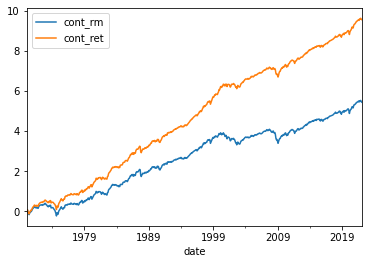

In [613]:
df_plot[['cont_rm', 'cont_ret']].cumsum().plot()